In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

import random
from typing import Callable
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

2024-04-04 13:14:04.669185: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 13:14:04.710180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 13:14:04.710224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 13:14:04.711222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 13:14:04.717254: I tensorflow/core/platform/cpu_feature_guar

>Justification des choix des données :

Dans le dessein de mieux appréhender le fonctionnement des autoencodeurs et d'illustrer leur capacité générative, nous avons pris la décision de construire un ensemble de données exclusivement composé d'images représentant les chiffres 1 et 7 (MNIST Digits). Les chiffres 1 et 7 présentent des similitudes marquées dans leur écriture. En introduisant divers types de bruits (dont nous discuterons ultérieurement), il devient possible de constituer un ensemble de données très varié et d'entraîner un modèle robuste. Par souci de performance et de faisabilité logistique, nous avons restreint notre choix à deux chiffres (1 et 7). Cependant, une exploration ultérieure sera proposée, où nous inclurons quatre chiffres (8, 5, 3 et 9) présentant des similitudes significatives.

>Justification des choix des bruits :

Deux types de bruits sont déjà implémentés, à savoir le "speckle" et le "gaussian".
- Le bruit speckle, également appelé bruit de chatoiement, fait référence à toute fluctuation parasite ou toute dégradation subie par une image depuis le moment de son acquisition jusqu'à son enregistrement. Ce bruit illustre un cas concret où l'image est capturée par un appareil numérique puis transmise au modèle, la présence de bruit étant inévitable. Ce type de bruit se distingue par sa capacité à séparer le premier plan de l'arrière-plan, ce qui met en valeur le chiffre tout en le dégradant.
- Le bruit gaussien, en traitement du signal, est un bruit caractérisé par une densité de probabilité qui suit une distribution gaussienne (loi normale). Les principales sources de bruit gaussien dans les images numériques surviennent pendant l'acquisition, par exemple le bruit du capteur causé par un mauvais éclairage et/ou une température élevée. Ce bruit uniforme permet au modèle d'être plus résilient dans sa classification car il n'accentue pas le chiffre mais uniformise la dégradation de l'image.
- Le bruit "salt and pepper", ou bruit sel ou poivre, correspond à une altération aléatoire subie par une image numérique, entraînant la modification de l'intensité de certains pixels (répartis de manière aléatoire dans l'image) jusqu'à atteindre la valeur minimale ou maximale de la plage dynamique du pixel, respectivement 0 et 255 dans le cas d'une image numérique codée en 8 bits. Ce type de bruit permet au modèle de traiter des valeurs extrêmes (0 ou 255).

Chacun des bruits sera scalé avec un paramètre `scale` qui permet de modifier l'intensité de la présence du bruit dans l'image. En jouant sur les valeurs de ce paramètre nous pourront créer des données plus ou moins bruitées et donc tester les limites de robustesse de nos modèles ainsi que de leur capacité à apprendre même avec beaucoup de bruit.



In [2]:
"""
Here we load the dataset, add gaussian,poisson,speckle

    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
    'salt_and_pepper' Randomly chosen pixels that are converted in black or white based on a probability.
    'scale' : the scale at which the noise is present in the image. It allows to create images with little to no noise and images with a lot of noise (for model robustness).
                
We define a function that adds each noise when called from main function
Input & Output: np array
"""

def add_noise(img, noise_type="gaussian", scale=0.5):
  row, col = 28, 28
  img = img.astype(np.float32)

  match noise_type:
    case "gaussian":
      mean  = 0
      var   = 0.01
      sigma = var**.5
      noise = np.random.normal(mean, sigma, img.shape)
      noise = noise.reshape(row, col)
      img   = img + (noise*scale)
      return img
     
    case "speckle" :
      noise = np.random.randn(row, col)
      noise = noise.reshape(row, col)
      img   = img + (img*noise*scale)
      return img
     
    case "salt_pepper" :
      prob = 0.4*scale # 1/4 is the base probability of a pixel being transformed. It is scaled down or up with the scale parameter
      output = img.copy()
      if len(img.shape) == 2:
          black = 0
          white = 1
        
      probs = np.random.random(output.shape[:2])
      output[probs < (prob/2)] = black
      output[probs > 1-(prob/2)] = white
      return output     
    case _:
      return img


In [3]:
mnist_ = mnist.load_data()

train_mask = (mnist_[0][1] == 1) | (mnist_[0][1] == 7)
test_mask = (mnist_[1][1] == 1) | (mnist_[1][1] == 7)

(xtrain, ytrain) = mnist_[0][0][train_mask], mnist_[0][1][train_mask]
(xtest, ytest) = mnist_[1][0][test_mask], mnist_[1][1][test_mask]

In [4]:
xtrain = np.array([minmax_scale(x) for x in xtrain])
xtest = np.array([minmax_scale(x) for x in xtest])

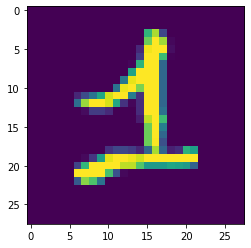

In [5]:
plt.imshow(xtrain[6].reshape((28, 28)))

In [6]:
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

No of training datapoints:13007
No of Test datapoints:2163


In [7]:
"""
From here onwards,we split the 60k training datapoints into 3 sets each given one type of each noise.
We shuffle them for better generalization.
"""
noises = ["gaussian", "speckle", "salt_pepper"]
noise_ct = 0
noise_id = 0
traindata = np.zeros((len(xtrain), 28, 28))


for idx in tqdm(range(len(xtrain))):
  if noise_ct < len(xtrain)/3:
    noise_ct += 1
    traindata[idx] = add_noise(xtrain[idx], noise_type=noises[noise_id], scale=1)
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0


print("\n{} noise addition completed to images".format(noises[noise_id])) 


noise_ct = 0
noise_id = 0
testdata = np.zeros((10000, 28, 28))

for idx in tqdm(range(len(xtest))):
  if noise_ct < len(xtest)/3:
    noise_ct += 1
    x = add_noise(xtest[idx], noise_type=noises[noise_id])
    testdata[idx] = x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0

print("\n{} noise addition completed to images".format(noises[noise_id]))    
  

 58%|█████▊    | 7536/13007 [00:00<00:00, 24668.63it/s]


gaussian noise addition completed to images

speckle noise addition completed to images


100%|██████████| 13007/13007 [00:00<00:00, 26667.62it/s]



salt_pepper noise addition completed to images


100%|██████████| 2163/2163 [00:00<00:00, 32294.89it/s]


gaussian noise addition completed to images

speckle noise addition completed to images

salt_pepper noise addition completed to images


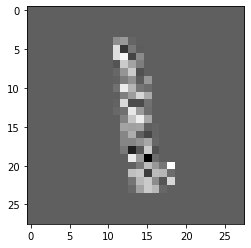

In [8]:
plt.imshow(traindata[5000], cmap="gray")

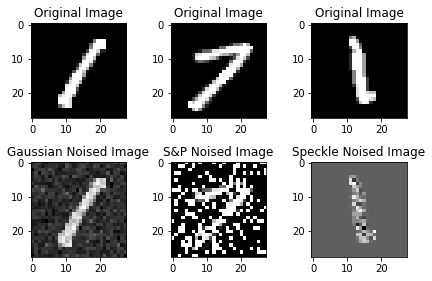

In [9]:
"""
Here we Try to visualize, each type of noise that was introduced in the images
Along with their original versions

"""

f, axes=plt.subplots(2,3)

#showing images with gaussian noise
axes[0,0].imshow(xtrain[0], cmap="gray")
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0], cmap='gray')
axes[1,0].set_title("Gaussian Noised Image")

#showing images with salt and pepper noise
axes[0,1].imshow(xtrain[13000], cmap='gray')
axes[0,1].set_title("Original Image")
axes[1,1].imshow(traindata[13000], cmap="gray")
axes[1,1].set_title("S&P Noised Image")

#showing imags with the speckle noise
axes[0,2].imshow(xtrain[5000], cmap='gray')
axes[0,2].set_title("Original Image")
axes[1,2].imshow(traindata[5000], cmap="gray")
axes[1,2].set_title("Speckle Noised Image")

plt.tight_layout()

In [10]:
class noisedDataset(Dataset):
  def __init__(self, 
               datasetnoised: np.ndarray, 
               datasetclean: np.ndarray, 
               labels: np.ndarray,
               transform: Callable):
    self.noise = datasetnoised
    self.clean = datasetclean
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self, idx):
    xNoise = self.noise[idx]
    xClean = self.clean[idx]
    y = self.labels[idx]
    
    if self.transform != None:
      xNoise = self.transform(xNoise)
      xClean = self.transform(xClean)

    return (xNoise, xClean, y)
    

In [11]:
tsfms = transforms.Compose([
    transforms.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [12]:
trainset.clean[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [13]:
"""
Here , we create the trainloaders and testloaders.
Also, we transform the images using standard lib functions
"""

batch_size = 32

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader  = DataLoader(testset, batch_size=1, shuffle=True)

In [52]:
"""
Here, we define the autoencoder model.
"""

class denoising_model(nn.Module):
  """
  Autoencodeur, capable d'être personnalisé au niveau du nombre de neurones dans la / les couche(s) cachée(s) et au nombre de couches cachées.

  Paramètres :
  ------------
  `hidden_layer_nb`: int (default=1)  
    Nombre de couche cachées
  `hidden_size`: int (default=256)
    Nombre de neurones dans chaque couche de la couche cachée
  `latent_size`: int (default=64)  
    Nombre de neurone dans la zone latente
  """
  def __init__(self, hidden_layer_nb=1, hidden_size = 256, latent_size=64, img_size=28*28):
    super(denoising_model,self).__init__()

    encode_sequence_input = [nn.Linear(img_size, hidden_size), nn.ReLU()]
    encode_sequence_output = [nn.Linear(hidden_size, latent_size), nn.ReLU()]
    encode_sequence_hidden = []
    for i in range(hidden_layer_nb):
      encode_sequence_hidden.append(nn.Linear(hidden_size, hidden_size))
      encode_sequence_hidden.append(nn.ReLU())

    encode_sequence = encode_sequence_input + encode_sequence_hidden + encode_sequence_output
        
    self.encoder = nn.Sequential(
      *encode_sequence
    )

    decode_sequence_input = [nn.Linear(latent_size, hidden_size), nn.ReLU()]
    decode_sequence_output = [nn.Linear(hidden_size, img_size), nn.Sigmoid()]
    decode_sequence_hidden = []
    for i in range(hidden_layer_nb):
      decode_sequence_hidden.append(nn.Linear(hidden_size, hidden_size))
      decode_sequence_hidden.append(nn.ReLU())

    decode_sequence = decode_sequence_input + decode_sequence_hidden + decode_sequence_output

    self.decoder = nn.Sequential(
      *decode_sequence
    )
 
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    
    return x

In [15]:
#We check whether cuda is available and choose device accordingly
if torch.cuda.is_available() == True:
  device = "cuda:0"
else:
  device = "cpu"

In [16]:
model = denoising_model(hidden_layer_nb=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

In [17]:
print(model)

denoising_model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [18]:
epochs = 120
l = len(trainloader)
losslist = list()
epochloss = 0
running_loss = 0
for epoch in range(epochs):
  break
  print("Entering Epoch: ", epoch)
  for dirty, clean, label in tqdm((trainloader)):
    
    
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor)
    dirty, clean = dirty.to(device), clean.to(device)

    optimizer.zero_grad()

    #-----------------Forward Pass----------------------
    output = model(dirty)
    loss = criterion(output, clean)

    #-----------------Backward Pass---------------------
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    epochloss += loss.item()
  #-----------------Log-------------------------------
  losslist.append(running_loss/l)
  running_loss = 0
  print("======> epoch: {}/{}, Loss:{}".format(epoch, epochs, loss.item()))
 

In [32]:
def train_test(
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        criterion: torch.nn.Module, 
        epochs: int,
        device: str,
        trainloader: torch.utils.data.DataLoader, 
        testset: torch.utils.data.Dataset):
    """
    Fonction pour entraîner / tester un modèle.

    Parameters:
    -----------
    model : torch.nn.Module
        Le modèle à entraîner.
    optimizer : torch.optim.Optimizer
        L'optimiseur utilisé pour la mise à jour des poids du modèle.
    criterion : torch.nn.Module
        La fonction de perte utilisée pour évaluer la différence entre les prédictions et les vraies étiquettes.
    epochs : int
        Le nombre d'époques d'entraînement.
    device : str
        L'appareil sur lequel exécuter l'entraînement, par exemple 'cuda' pour GPU ou 'cpu' pour CPU.
    trainloader : torch.utils.data.DataLoader
        Le DataLoader contenant les données d'entraînement.
    testset : torch.utils.data.Dataset
        Le jeu de données de test utilisé pour évaluer le modèle après chaque époque.

    Returns:
    --------
    true_error : float
        L'erreur moyenne quadratique sur le jeu de données de test.
    losslist : list
        Liste des valeurs de la fonction de perte moyenne sur les données d'entraînement pour chaque époque.
    """
    model.train()
    for epoch in tqdm(range(epochs)):
        running_loss = 0
        for dirty, clean, label in trainloader:  
            
            dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
            clean = clean.view(clean.size(0), -1).type(torch.FloatTensor)
            dirty, clean = dirty.to(device), clean.to(device)

            optimizer.zero_grad()

            # Forward pass
            output = model(dirty)
            loss = criterion(output, clean)

            # Rétropropagation
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Calcul de la perte moyenne pour cette époque
        losslist.append(running_loss/l)

    # Calcul de l'erreur moyenne quadratique sur le jeu de données de test
    true_error = 0
    for test in testset:
        true_error += mean_squared_error(test[0][0].flatten(), model(test[0].view(test[0].size(0), -1).type(torch.FloatTensor)).detach()[0])
    true_error /= len(testset)

    return true_error, losslist

In [20]:
train_test(model, optimizer, criterion, 120, device, trainloader, testdata)

  3%|▎         | 4/120 [00:21<10:30,  5.44s/it]


KeyboardInterrupt: 

In [21]:
def gridsearch(model_obj: nn.Module, 
               parameters: dict,
               optimizer: optim.Optimizer,
               learning_rate :int,
               epoch: int,
               device: str,
               trainloader: DataLoader,
               testdata: Dataset):
    """
    Effectue une recherche sur grille pour trouver les meilleurs hyperparamètres pour un modèle donné.

    Parameters:
    -----------
    model_obj : nn.Module
        Classe du modèle à utiliser pour la recherche sur grille.
    parameters : dict
        Dictionnaire contenant les hyperparamètres à tester.
    optimizer : torch.optim.Optimizer
        L'optimiseur à utiliser pour la mise à jour des poids du modèle.
    learning_rate : int
        Taux d'apprentissage à utiliser avec l'optimiseur.
    epoch : int
        Nombre d'époques d'entraînement pour chaque configuration de paramètres.
    device : str
        L'appareil sur lequel exécuter l'entraînement, par exemple 'cuda' pour GPU ou 'cpu' pour CPU.
    trainloader : torch.utils.data.DataLoader
        DataLoader contenant les données d'entraînement.
    testdata : torch.utils.data.Dataset
        Jeu de données de test utilisé pour évaluer le modèle après chaque configuration de paramètres.

    Returns:
    --------
    results : dict
        Dictionnaire contenant les résultats de la recherche sur grille.
        Chaque clé correspond à l'indice de la configuration de paramètres.
        Chaque valeur est un dictionnaire contenant les paramètres testés, l'erreur réelle (sur les données de test)
        et l'erreur d'entraînement (sur les données d'entraînement) pour cette configuration.
    """
    parameters = ParameterGrid(parameters)
    results = {}

    for i, params in enumerate(parameters):
        tmp_model = model_obj(**params)
        tmp_optim = optimizer(tmp_model.parameters(), lr=learning_rate)
        tmp_result = train_test(tmp_model, tmp_optim, epoch, device, trainloader, testdata)
        print(f"\tParams {i}/{len(parameters)} -> true error: {tmp_result[0]}")
        results[i] = {
            "params": params,
            "true_error": tmp_result[0],
            "training_error": tmp_result[1]
        }

    return results

In [22]:
parameters = {"hidden_layer_nb": range(1, 7, 2),
              "hidden_size": range(200, 501, 100),
              "latent_size": range(50, 201, 50)}

In [23]:
# results = gridsearch(denoising_model, parameters, optim.Adam, 1e-4, 50, device, trainloader, testdata)

Afin de trouver le meilleur modèle pour cette tâche, nous avons réalisé un grid search sur plusieurs paramètres :
- Le nombre de couches de la couche cachée (par le paramètres `hidden_layer_nb`)
- Le nombre de neurones de la couche cachées (par le paramètres `hidden_size`)
- Le nombre de neurones de la zone latente (par le paramètres `latent_size`)  

Nous n'avons fait que 50 itérations par test dans le grid search, par faute de temps (le programme a tourné pendant plus de 3 heures rien qu'avec 50 itérations). Nous utilisions le même optimiseur et pas d'apprentissage que dans notre premier test.  

Le meilleur modèle possède donc cette forme :
```
denoising_model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=50, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
```
C'est à dire, par rapport aux paramètres donnés :
- Le paramètre `hidden_layer_nb` vaut 1
- Le paramètre `hidden_size` vaut 500
- Le paramètre `latent_size` vaut 50

In [24]:
with open("output_gridsearch.txt") as file:
    results = eval(file.read())

In [25]:
type(results)

dict

In [26]:
best_model = denoising_model(**[results[j]["params"] for j in range(48) if results[j]["true_error"] == min([results[i]["true_error"] for i in range(48)])][0])
print(best_model)

denoising_model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=50, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [34]:
best_model_optim = optim.Adam(best_model.parameters(), lr=5e-3)
best_model_criterion = nn.MSELoss()

In [35]:
true_error, losslist = train_test(best_model, best_model_optim, best_model_criterion, 120, device, trainloader, testdata)

100%|██████████| 120/120 [09:51<00:00,  4.93s/it]


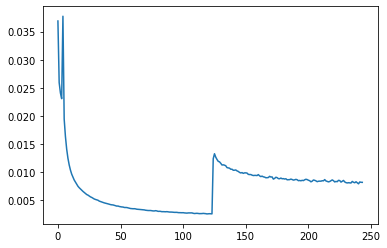

In [36]:
plt.plot(range(len(losslist)), losslist)

In [37]:
true_error

0.010816367424779762

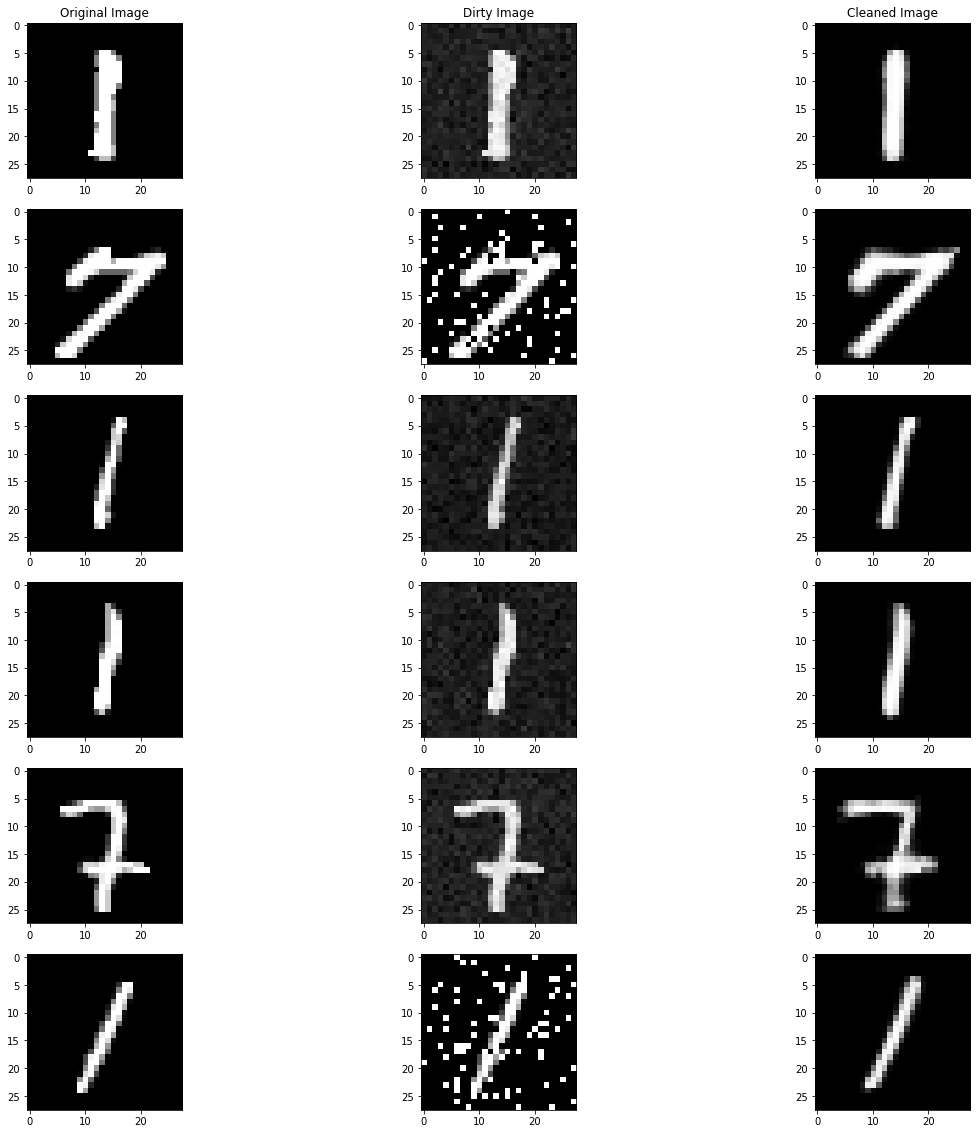

In [51]:
"""
Here, we try to visualize some of the results.
We randomly generate 6 numbers in between 1 and 10k , run them through the model,
and show the results with comparisons
"""
f,axes= plt.subplots(6,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

test_imgs=np.random.randint(0,len(xtest),size=6)
for idx in range((6)):
  dirty=testset[test_imgs[idx]][0]
  clean=testset[test_imgs[idx]][1]
  label=testset[test_imgs[idx]][2]
  dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
  dirty=dirty.to(device)
  output=best_model(dirty)
  
  output=output.view(1,28,28)
  output=output.permute(1,2,0).squeeze(2)
  output=output.detach().cpu().numpy()
  
  dirty=dirty.view(1,28,28)
  dirty=dirty.permute(1,2,0).squeeze(2)
  dirty=dirty.detach().cpu().numpy()
  
  clean=clean.permute(1,2,0).squeeze(2)
  clean=clean.detach().cpu().numpy()
  
  axes[idx,0].imshow(clean,cmap="gray")
  axes[idx,1].imshow(dirty,cmap="gray")
  axes[idx,2].imshow(output,cmap="gray")

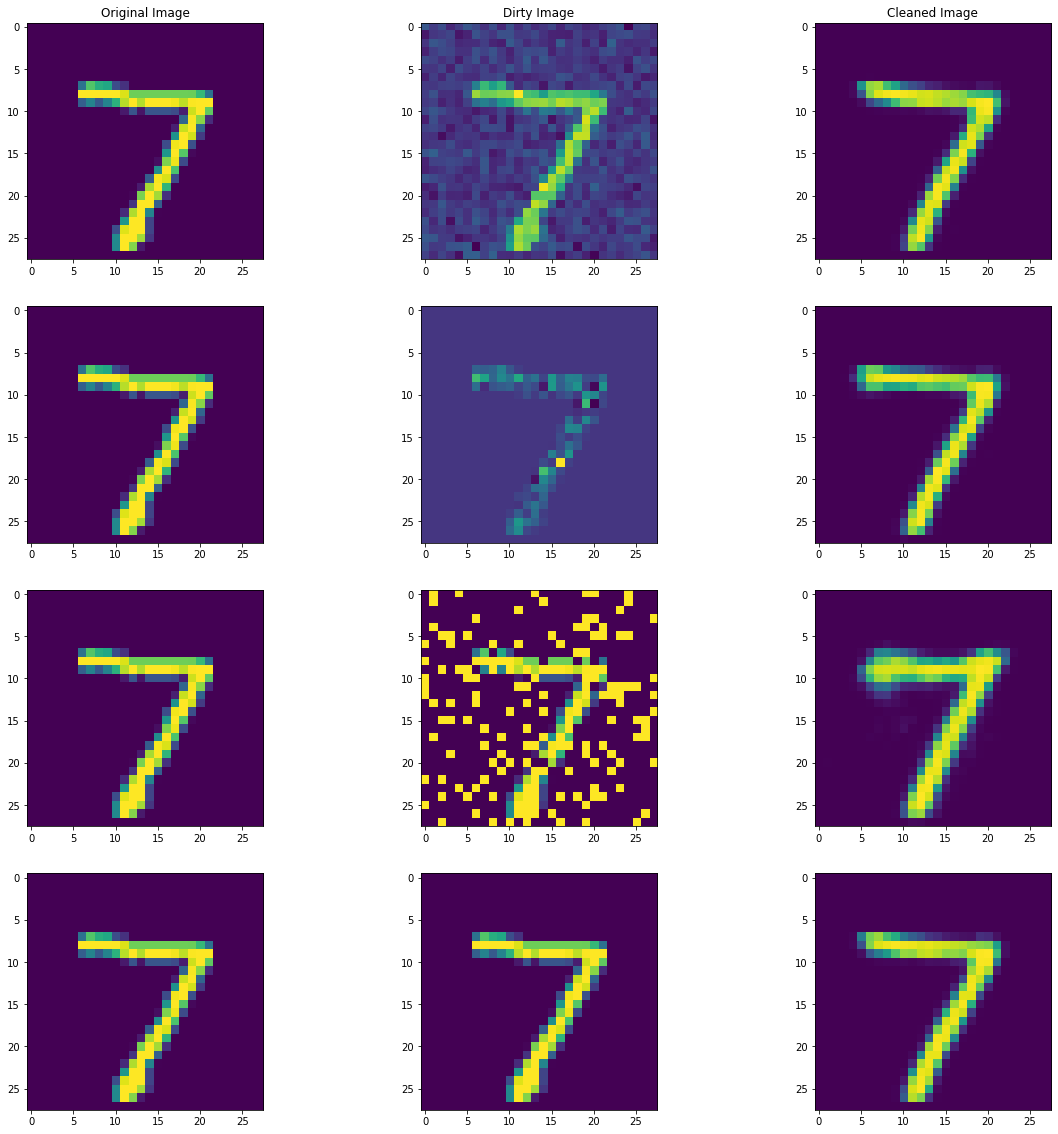

In [74]:
f,axes= plt.subplots(4,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")
for i, noise in enumerate(["gaussian", "speckle", "salt_pepper", ""]):
    dirty = add_noise(np.array(xtest[0]), noise, 0.8)
    predicted = best_model(torch.tensor(dirty.flatten()).type(torch.FloatTensor))

    axes[i, 0].imshow(xtest[0])
    axes[i, 1].imshow(dirty.reshape((28, 28)))
    axes[i, 2].imshow(predicted.detach().numpy().reshape((28, 28)))

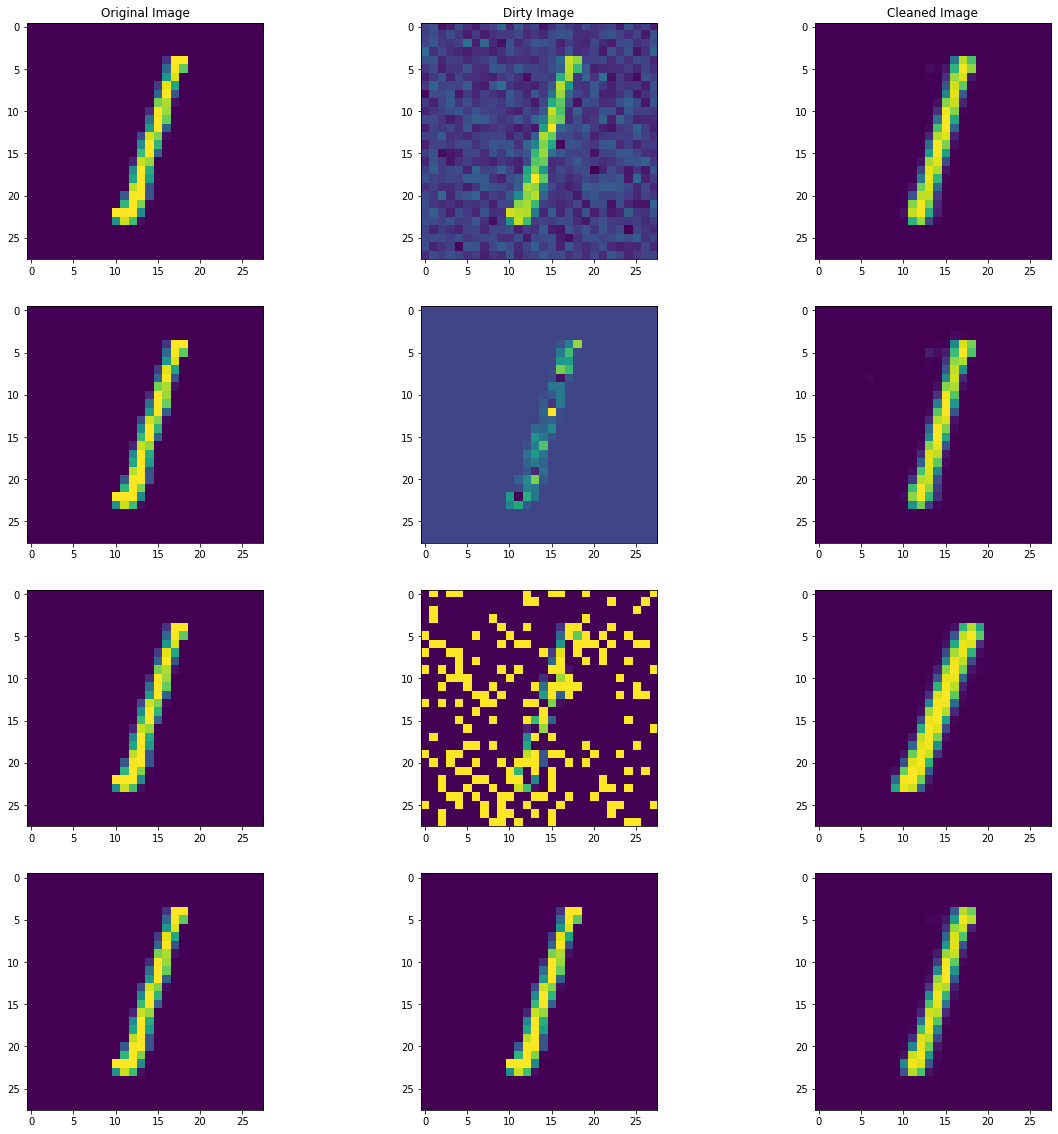

In [77]:
f,axes= plt.subplots(4,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")
for i, noise in enumerate(["gaussian", "speckle", "salt_pepper", ""]):
    dirty = add_noise(np.array(xtest[1]), noise, 1)
    predicted = best_model(torch.tensor(dirty.flatten()).type(torch.FloatTensor))

    axes[i, 0].imshow(xtest[1])
    axes[i, 1].imshow(dirty.reshape((28, 28)))
    axes[i, 2].imshow(predicted.detach().numpy().reshape((28, 28)))

In [57]:
testset[0]

(tensor([[[ 3.4135e-02,  4.4195e-02, -7.7380e-02,  2.4751e-02, -5.0863e-02,
            2.5114e-02,  4.9133e-02, -1.3340e-02, -6.4584e-02,  4.4673e-02,
            3.8700e-02,  7.1824e-02, -5.7340e-02,  2.7726e-02,  3.4127e-02,
            9.7606e-03,  7.1653e-02,  6.6748e-03, -2.9927e-02, -1.5144e-02,
            1.5638e-03, -4.4480e-02,  3.1359e-02,  2.6113e-03,  1.0819e-01,
           -6.4017e-03,  6.9346e-02,  2.7335e-02],
          [-7.9216e-03, -1.5361e-02, -1.1934e-02,  4.4120e-02, -8.1925e-02,
            1.4423e-01,  4.1251e-02,  2.0630e-02, -5.2764e-02, -1.1604e-01,
           -3.2103e-03, -2.5719e-02, -2.7238e-02, -1.0678e-01, -8.7950e-02,
            1.2407e-02,  8.9346e-02,  5.1666e-02, -5.8137e-02,  1.2065e-02,
            2.9289e-03,  3.0549e-02,  1.0795e-02, -8.6446e-02,  3.9240e-02,
           -2.2157e-02,  1.3047e-01,  3.8005e-02],
          [ 6.2730e-02,  1.7873e-02, -1.3907e-02, -3.1164e-02, -2.8612e-02,
            8.9958e-02, -6.3258e-02, -4.0867e-03, -1.1132e-02,

In [53]:
PATH = "model"
torch.save(best_model.state_dict(), PATH)  # We save the model state dict at PATH   